# Loan Approval Prediction
**Project:** Predict whether a loan application will be approved using applicant and loan features.  
**Goal:** Build, evaluate, and compare classification models; handle class imbalance; present a clean, reproducible Google Colab notebook ready for submission.

---
**How to use:** Upload the Kaggle "Loan Approval Prediction Dataset" CSV file when prompted (usually named like `loan.csv` or similar). Every cell is commented and explained. Run the notebook top-to-bottom in Google Colab.

## Import Libraries

Install necessary packages (run in Colab). Then import commonly used libraries.

In [28]:
# Uncomment the pip installs if running in a fresh Colab environment
# !pip install -q imbalanced-learn
# !pip install -q xgboost

import warnings
warnings.filterwarnings('ignore')

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Modeling & preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay

# Imbalanced data
from imblearn.over_sampling import SMOTE

print('Libraries imported successfully')

Libraries imported successfully


## Load Dataset

Upload the dataset CSV file from your local machine or Google Drive. If running in Colab, use the file upload widget.

In [29]:
# If in Colab, run this cell to upload the dataset file
try:
    from google.colab import files
    uploaded = files.upload()
    # take the first uploaded file
    filename = list(uploaded.keys())[0]
    print(f'Uploaded file: {filename}')
    df = pd.read_csv(filename)
except Exception as e:
    print("If not using Colab, make sure the CSV file is in the working directory and change the filename below.")
    # fallback filename (user should edit as needed)
    filename = 'loan.csv'
    df = pd.read_csv(filename)

# Quick look
print('Shape:', df.shape)
df.head()

Saving loan.csv to loan (2).csv
Uploaded file: loan (2).csv
Shape: (614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## Data Cleaning & Preprocessing

Handle missing values, encode categorical variables, and scale numeric features. We'll create a preprocessing pipeline so it is reproducible.

In [30]:
# Overview of dataset
df.info()
df.describe(include='all').T

# Copy of dataframe to work on
data = df.copy()

# Detect categorical and numerical columns automatically if not provided
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

# Basic missing value handling strategy
# For categorical: fill with mode. For numeric: fill with median.
from sklearn.impute import SimpleImputer
cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='median')

# We'll encode categorical columns using OneHotEncoder for low-cardinality cols.
low_card_cols = [c for c in categorical_cols if data[c].nunique() <= 6 and c!='Loan_ID']
high_card_cols = [c for c in categorical_cols if c not in low_card_cols and c!='Loan_ID']

print("Low-card categorical:", low_card_cols)
print("High-card categorical:", high_card_cols)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

numeric_transformer = Pipeline(steps=[
    ('imputer', num_imputer),
    ('scaler', StandardScaler())
])

# Separate target and features
possible_targets = ['Loan_Status','Loan_Status_Y','target','Approved','LoanDecision']
target_col = None
for t in possible_targets:
    if t in data.columns:
        target_col = t
        break
if target_col is None:
    # fallback: assume the last column is the target
    target_col = data.columns[-1]
print('Detected target column:', target_col)

# Remove target column from categorical_cols before creating the preprocessor
categorical_cols_for_processing = [c for c in categorical_cols if c != target_col and c != 'Loan_ID']

categorical_transformer = Pipeline(steps=[
    ('imputer', cat_imputer),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols_for_processing)
])


X = data.drop(columns=[target_col, 'Loan_ID']) # Also drop Loan_ID as it's not a feature
y = data[target_col]

# If target is string like 'Y'/'N', encode it
if y.dtype == 'O':
    le_target = LabelEncoder()
    y = le_target.fit_transform(y)
    print('Target classes:', le_target.classes_)

print('Feature shape:', X.shape, 'Target shape:', y.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
Categorical columns: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area

## Exploratory Data Analysis (EDA)

Visualize class balance, distributions, and correlations.

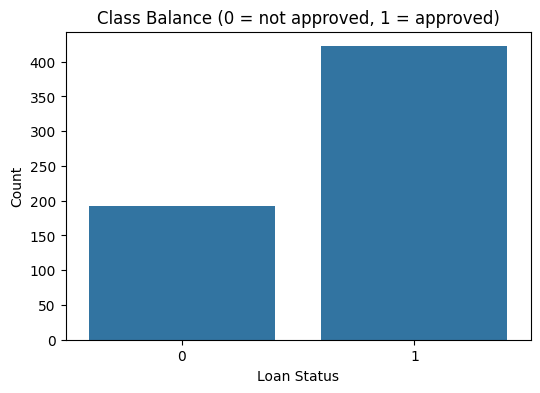

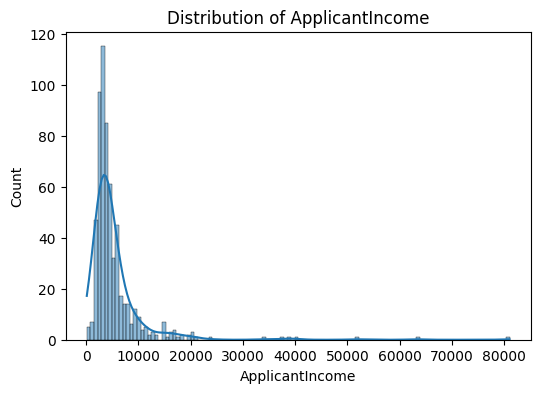

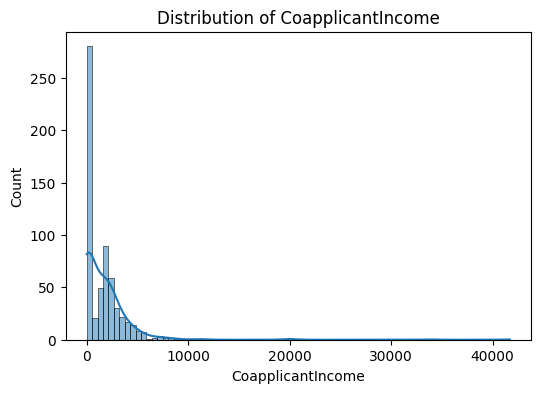

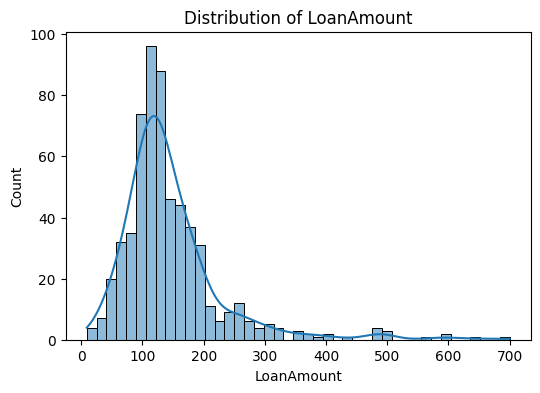

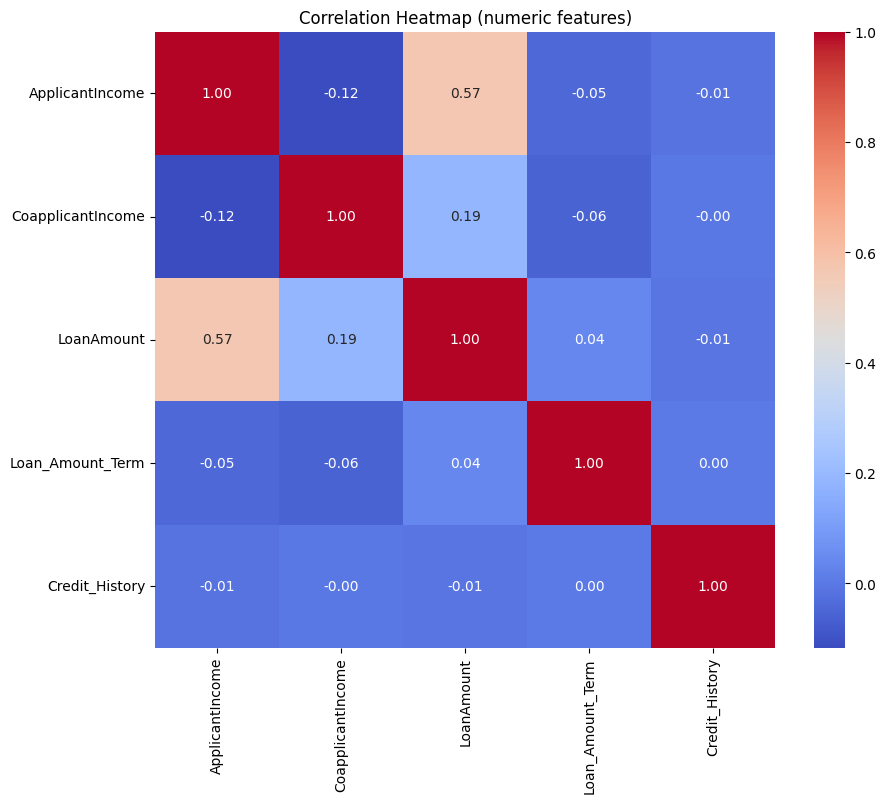

In [31]:
# Class balance
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title('Class Balance (0 = not approved, 1 = approved)')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.show()

# Key numerical distributions: show histograms for ApplicantIncome, CoapplicantIncome, LoanAmount if present
for col in ['ApplicantIncome','CoapplicantIncome','LoanAmount']:
    if col in X.columns:
        plt.figure(figsize=(6,4))
        sns.histplot(X[col].dropna(), kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.show()

# Correlation heatmap (numeric columns only)
numeric_only = X.select_dtypes(include=[np.number])
if numeric_only.shape[1] > 0:
    corr = numeric_only.corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap (numeric features)')
    plt.show()
else:
    print('No numeric columns to show correlation.')

## Train-Test Split

Split data into training and testing sets. Use stratify to keep class proportions.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (491, 11) Test shape: (123, 11)


## Model Training - Baseline Models

Train Logistic Regression and Decision Tree with preprocessing pipeline.

In [33]:
from sklearn.base import clone

def build_pipeline(model):
    return Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', model)])

# Baseline models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42)
}

fitted_models = {}
for name, model in models.items():
    pipe = build_pipeline(model)
    pipe.fit(X_train, y_train)
    fitted_models[name] = pipe
    print(f'{name} trained.')

LogisticRegression trained.
DecisionTree trained.


## Evaluation Metrics

Evaluate models on test set using precision, recall, F1-score, accuracy, ROC-AUC, and plot confusion matrices.

== LogisticRegression Evaluation ==
Accuracy: 0.8618
Precision: 0.8400
Recall: 0.9882
F1-score: 0.9081
ROC-AUC: 0.8523

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.58      0.72        38
           1       0.84      0.99      0.91        85

    accuracy                           0.86       123
   macro avg       0.90      0.78      0.81       123
weighted avg       0.88      0.86      0.85       123



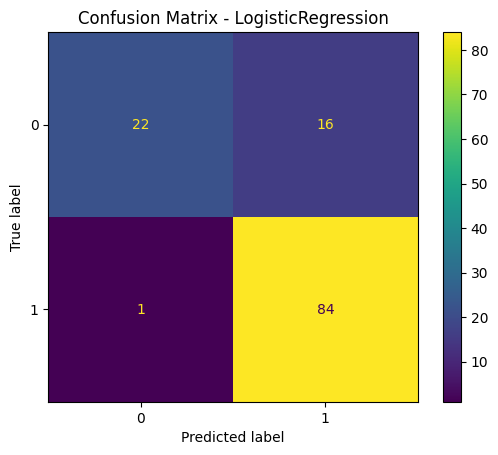

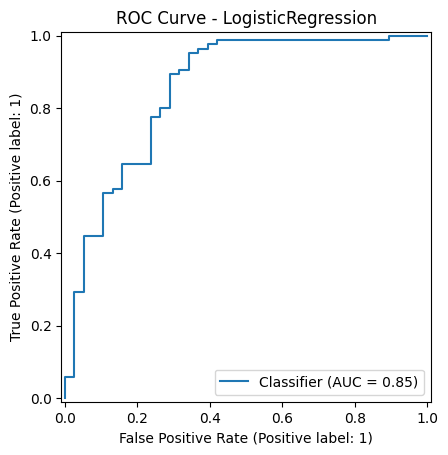

== DecisionTree Evaluation ==
Accuracy: 0.7561
Precision: 0.8235
Recall: 0.8235
F1-score: 0.8235
ROC-AUC: 0.7144

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.61      0.61        38
           1       0.82      0.82      0.82        85

    accuracy                           0.76       123
   macro avg       0.71      0.71      0.71       123
weighted avg       0.76      0.76      0.76       123



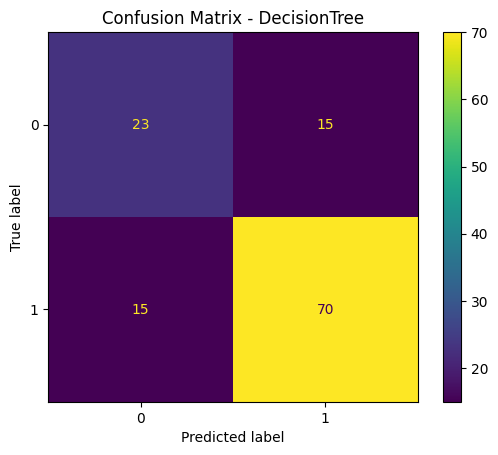

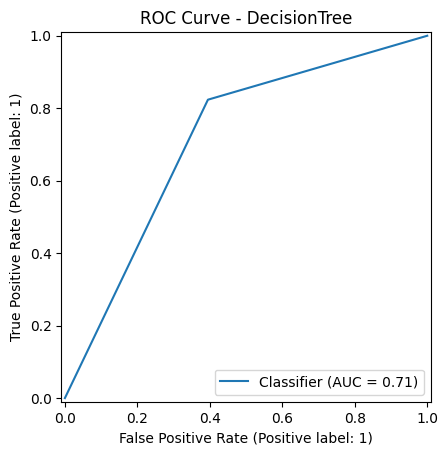

In [34]:
def evaluate_model(pipe, X_test, y_test, model_name='Model'):
    y_pred = pipe.predict(X_test)
    y_proba = None
    try:
        y_proba = pipe.predict_proba(X_test)[:,1]
    except:
        try:
            y_proba = pipe.decision_function(X_test)
        except:
            y_proba = None
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    print(f'== {model_name} Evaluation ==')
    print('Accuracy: {:.4f}'.format(acc))
    print('Precision: {:.4f}'.format(prec))
    print('Recall: {:.4f}'.format(rec))
    print('F1-score: {:.4f}'.format(f1))
    print('ROC-AUC: {:.4f}'.format(roc))
    print('\nClassification Report:\n', classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    # ROC curve
    if y_proba is not None:
        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.title(f'ROC Curve - {model_name}')
        plt.show()

    return {'accuracy':acc,'precision':prec,'recall':rec,'f1':f1,'roc_auc':roc}

# Evaluate baseline models
results_baseline = {}
for name, pipe in fitted_models.items():
    results_baseline[name] = evaluate_model(pipe, X_test, y_test, model_name=name)

## Handling Class Imbalance

Use SMOTE to oversample the minority class on the training set, then retrain models and compare performance.

Preprocessed shapes: (491, 20) (123, 20)
After SMOTE, counts: [337 337]
LogisticRegression trained on resampled data.
DecisionTree trained on resampled data.
== LogisticRegression (resampled) Evaluation ==
Accuracy: 0.8211
Precision: 0.8621
Recall: 0.8824
F1-score: 0.8721
ROC-AUC: 0.8759

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.68      0.70        38
           1       0.86      0.88      0.87        85

    accuracy                           0.82       123
   macro avg       0.79      0.78      0.79       123
weighted avg       0.82      0.82      0.82       123



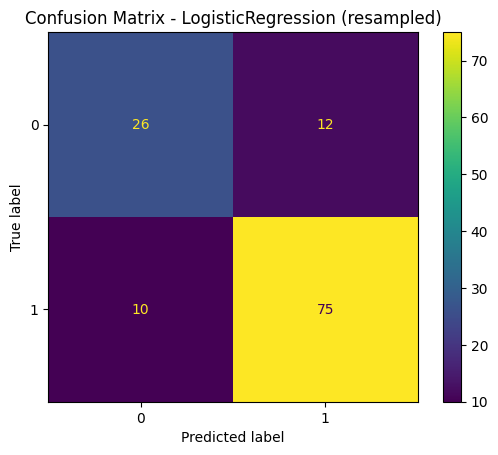

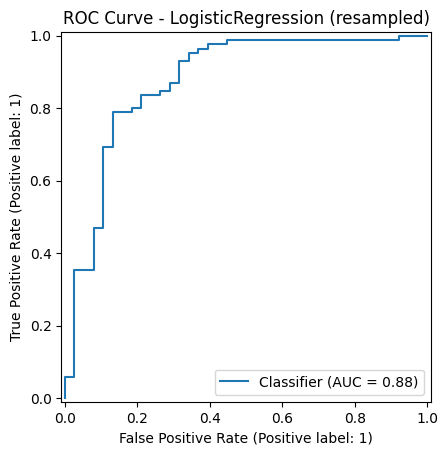

== DecisionTree (resampled) Evaluation ==
Accuracy: 0.7398
Precision: 0.8533
Recall: 0.7529
F1-score: 0.8000
ROC-AUC: 0.7317

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.71      0.63        38
           1       0.85      0.75      0.80        85

    accuracy                           0.74       123
   macro avg       0.71      0.73      0.71       123
weighted avg       0.76      0.74      0.75       123



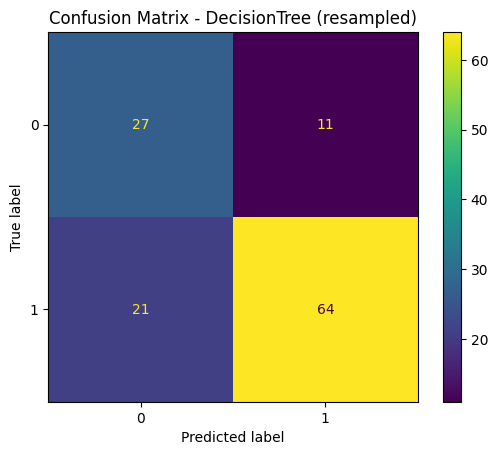

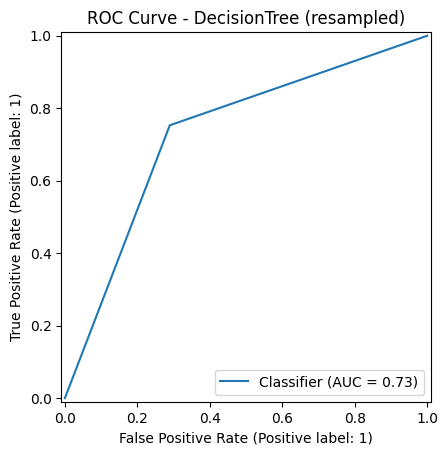

In [35]:
# Apply preprocessing separately to get numeric arrays for SMOTE
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

print('Preprocessed shapes:', X_train_prep.shape, X_test_prep.shape)

# Apply SMOTE on training data
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_prep, y_train)
print('After SMOTE, counts:', np.bincount(y_res))

# Train models on resampled data (note: classifiers expect arrays now)
from sklearn.base import clone
resampled_models = {}
for name, model in models.items():
    m = clone(model)
    m.fit(X_res, y_res)
    resampled_models[name] = m
    print(f'{name} trained on resampled data.')

# Evaluation helper for models trained on arrays
def evaluate_array_model(model, X_test_prep, y_test, model_name='Model'):
    y_pred = model.predict(X_test_prep)
    try:
        y_proba = model.predict_proba(X_test_prep)[:,1]
    except:
        try:
            y_proba = model.decision_function(X_test_prep)
        except:
            y_proba = None
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    print(f'== {model_name} (resampled) Evaluation ==')
    print('Accuracy: {:.4f}'.format(acc))
    print('Precision: {:.4f}'.format(prec))
    print('Recall: {:.4f}'.format(rec))
    print('F1-score: {:.4f}'.format(f1))
    print('ROC-AUC: {:.4f}'.format(roc))
    print('\nClassification Report:\n', classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix - {model_name} (resampled)')
    plt.show()

    if y_proba is not None:
        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.title(f'ROC Curve - {model_name} (resampled)')
        plt.show()

    return {'accuracy':acc,'precision':prec,'recall':rec,'f1':f1,'roc_auc':roc}

results_resampled = {}
for name, model in resampled_models.items():
    results_resampled[name] = evaluate_array_model(model, X_test_prep, y_test, model_name=name)

## Compare Performance Before and After Resampling

In [36]:
import pandas as pd
rows = []
for k,v in results_baseline.items():
    rows.append((k + ' (baseline)', v))
for k,v in results_resampled.items():
    rows.append((k + ' (resampled)', v))
df_compare = pd.DataFrame({name: metrics for name, metrics in rows}).T
df_compare

,accuracy,precision,recall,f1,roc_auc
LogisticRegression (baseline),0.861789,0.840000,0.988235,0.908108,0.852322
DecisionTree (baseline),0.756098,0.823529,0.823529,0.823529,0.714396
LogisticRegression (resampled),0.821138,0.862069,0.882353,0.872093,0.875851
DecisionTree (resampled),0.739837,0.853333,0.752941,0.800000,0.731734


## Bonus: Hyperparameter Tuning & Advanced Models

Perform GridSearchCV for the best model and try Random Forest and XGBoost.

RandomForest CV ROC-AUC mean: 0.7598 std: 0.0350
XGBoost CV ROC-AUC mean: 0.7605 std: 0.0323
Best RF params: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
== RandomForest (GridSearch Best) Evaluation ==
Accuracy: 0.8211
Precision: 0.8462
Recall: 0.9059
F1-score: 0.8750
ROC-AUC: 0.7808

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.63      0.69        38
           1       0.85      0.91      0.88        85

    accuracy                           0.82       123
   macro avg       0.80      0.77      0.78       123
weighted avg       0.82      0.82      0.82       123



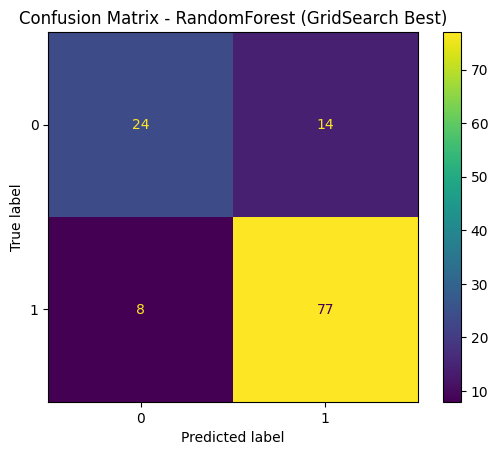

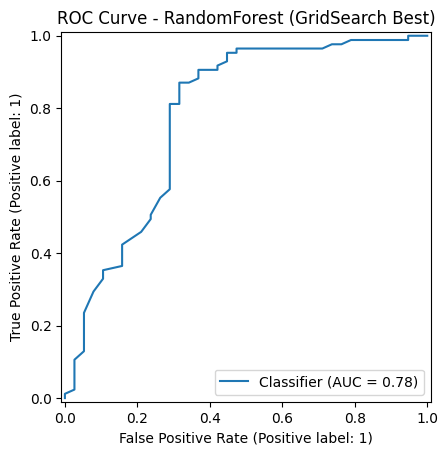

{'accuracy': 0.8211382113821138,
 'precision': 0.8461538461538461,
 'recall': 0.9058823529411765,
 'f1': 0.875,
 'roc_auc': np.float64(0.7808049535603715)}

In [37]:
# Try RandomForest and XGBoost using pipelines
rf_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', RandomForestClassifier(random_state=42))])

xgb_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))])

# Quick cross-validation score for each
for name, pipe in [('RandomForest', rf_pipe), ('XGBoost', xgb_pipe)]:
    scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
    print(f'{name} CV ROC-AUC mean: {scores.mean():.4f} std: {scores.std():.4f}')

# GridSearch for the RandomForest as example
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 6, 12],
    'classifier__min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(rf_pipe, param_grid=param_grid_rf, cv=3, scoring='roc_auc', n_jobs=-1)
grid_rf.fit(X_train, y_train)
print('Best RF params:', grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

# Evaluate best RF on test set
evaluate_model(best_rf, X_test, y_test, model_name='RandomForest (GridSearch Best)')